<a href="https://colab.research.google.com/github/YeyoM/Not_Hotdog_Model/blob/main/Not_Hotdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Not Hotdog?

In this notebook I will try to recreate a curious model used in an App shown in the HBO serie "Sillicon Valley".

For this model, I will use the hotdog-nothotdog dataset from Kaggle, and to build the model my way to go was to use Tensorflow using Keras layers to build a Convolutional Neural Network and a pre-trained model to make use of transfer learning from the mobileNet v2 model.

Along the notebook and the code blocks, I will try to explain as best as I can what the building process of this model works and at the end obviously the results I got.

Hopefully I can also build the App as in the serie with this model I built, which is my first model I built by my own.


## Get the dataset from Kaggle

Install kaggle, and upload our Kaggle key in a json file into the colab folder system.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yeyomoreno","key":"fb73195de55d141c0b4fbc6a21cf4324"}'}

Make a dir called kaggle and copy the file we just uploaded and give it permissions to act in the colab file system with chmod.

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

Download the dataset and unzip it.

In [ ]:
!kaggle datasets download -d thedatasith/hotdog-nothotdog

100% 211M/211M [00:11<00:00, 21.0MB/s]
100% 211M/211M [00:11<00:00, 18.6MB/s]


In [ ]:
!unzip hotdog-nothotdog.zip

Archive:  hotdog-nothotdog.zip
  inflating: README.md               
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/133012.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/133015.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/133245.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/135628.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/138933.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/138937.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/138969.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/139177.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/142835.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/143012.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/144956.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/146227.jpg  
  inflating: hotdog-nothotdog/hotdog-nothotdog/test/hotdog/146834.j

## Build the model

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import tensorflow_hub as hub       # To use mobilenet v2

import matplotlib.pylab as plt     # Plot images and graphs

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import numpy as np                 # numpy to operate tensors and more
import PIL.Image as Image

import os                          # To read directory structure
import glob                        # Help to read directories
import shutil                      # Do different high level documents functions

In [ ]:
# MobileNet v2 uses tensors of a dimension (160, 160, 3)
IMAGE_RES = (160, 160)
BATCH_SIZE = 32

In [ ]:
# We can take a look into the folder structure that we just downloaded
top_dir = os.path.join(os.path.dirname('hotdog-nothotdog'), 'hotdog-nothotdog')
base_dir = os.path.join(top_dir, 'hotdog-nothotdog')

print(os.listdir(base_dir))

['test', 'train']


In [ ]:
# We need training and validation data to train the model (get from train folder)
train_dir = os.path.join(base_dir, 'train')
hotdog_train_dir = os.path.join(train_dir, 'hotdog')
nothotdog_train_dir = os.path.join(train_dir, 'nothotdog')

print("Hotdog train images:  \t\t", len(os.listdir(hotdog_train_dir)))
print("Not hotdog train images: \t", len(os.listdir(nothotdog_train_dir)))

Hotdog train images:  		 2121
Not hotdog train images: 	 2121


In [ ]:
# Split each folder into training and validation folder in 80% to 20%.
classes = ['hotdog', 'nothotdog']

for class_ in classes:
  img_path = os.path.join(train_dir, class_)
  images = glob.glob(img_path + '/*.jpg')
  training = images[:round(len(images)*0.8)]
  validation = images[round(len(images)*0.8):]

  for t in training:
    if not os.path.exists(os.path.join(base_dir, 'training', class_)):
      os.makedirs(os.path.join(base_dir, 'training', class_))
    shutil.move(t, os.path.join(base_dir, 'training', class_))

  for v in validation:
    if not os.path.exists(os.path.join(base_dir, 'validation', class_)):
      os.makedirs(os.path.join(base_dir, 'validation', class_))
    shutil.move(v, os.path.join(base_dir, 'validation', class_))

In [ ]:
# Lets check the folders we just created
training_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

print(os.listdir(training_dir))
print(os.listdir(validation_dir))

['nothotdog', 'hotdog']
['nothotdog', 'hotdog']


In [ ]:
# Checking the number of images
hotdog_training_dir = os.path.join(training_dir, 'hotdog')
nothotdog_training_dir = os.path.join(training_dir, 'nothotdog')
print("Hotdog training images:  \t", len(os.listdir(hotdog_training_dir)))
print("Not hotdog training images: \t", len(os.listdir(nothotdog_training_dir)))

hotdog_validation_dir = os.path.join(validation_dir, 'hotdog')
nothotdog_validation_dir = os.path.join(validation_dir, 'nothotdog')
print("Hotdog validation images:  \t", len(os.listdir(hotdog_validation_dir)))
print("Not hotdog validation images: \t", len(os.listdir(nothotdog_validation_dir)))

Hotdog training images:  	 1697
Not hotdog training images: 	 1697
Hotdog validation images:  	 424
Not hotdog validation images: 	 424


In [ ]:
# We need test data to test the model (get from test folder)
test_dir = os.path.join(base_dir, 'test')
print(os.listdir(test_dir))

['nothotdog', 'hotdog']


In [ ]:
# Take our dataset but with keras.preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_dir,
    labels = 'inferred',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_RES,
    shuffle = True,
    seed = 82
)

Found 3394 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    labels = 'inferred',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_RES,
    shuffle = True,
    seed = 824312,
)

Found 848 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_RES,
    shuffle = True,
    seed = 8212343,
)

Found 400 files belonging to 2 classes.


In [ ]:
# Get the class names for later
class_names = train_ds.class_names

In [ ]:
# With AUTOTUNE we will have our dataseets with buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

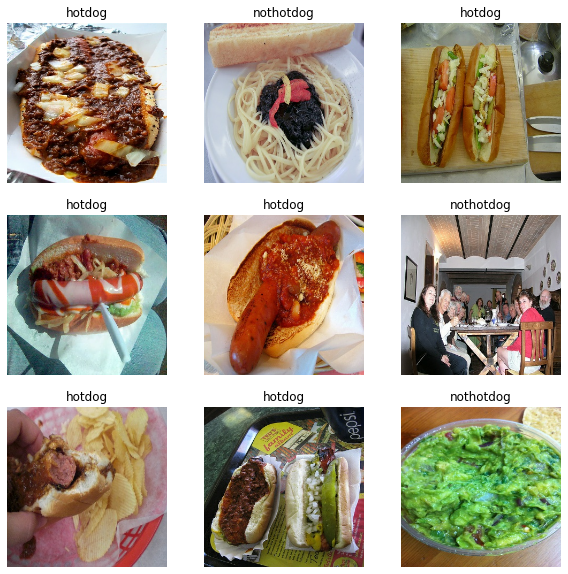

In [ ]:
# Plot out a few of the images and their labels so we can see what we're working with.
plt.figure(figsize = (10, 10))

# Take one batch from train dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1) # Define the dimension of the plot
        plt.imshow(images[i].numpy().astype("uint8")) # Show each image
        plt.title(class_names[labels[i]]) # With its own label
        plt.axis("off") # Turn off the plot labels  

In [ ]:
# This model expects pixel values in [-1, 1], but at this point, 
# the pixel values in the images are in [0, 255]. 
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMAGE_RES = IMAGE_RES + (3,) # Add the color channels to have (x, x, 3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMAGE_RES,
    include_top = False,
    weights = 'imagenet'
)

# You can take a look at the layers of mobileNet v2 with
# base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# This feature extractor converts each 160x160x3 image 
# into a 5x5x1280 block of features. 
# Let's see what it does to an example batch of images:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
# Freeze the convolutional base
base_model.trainable = False

In [ ]:
# To generate predictions from the block of features, 
# average over the spatial 5x5 spatial locations, 
# using a tf.keras.layers.GlobalAveragePooling2D layer 
# to convert the features to a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
# Apply a tf.keras.layers.Dense layer to convert these features into a 
# single prediction per image. You don't need an activation function 
# here because this prediction will be treated as a logit, 
# or a raw prediction value. Positive numbers predict class 1, 
# negative numbers predict class 0.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
# Build a layer for image augmentation to prevent possible overfitting 
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# Chain together all the previous layers to build the model

inputs = tf.keras.Input(shape = IMAGE_RES)

x = data_augmentation(inputs)         # First the data augmentation layer
x = preprocess_input(x)               # Then, the preprocess input layer for the base model
x = base_model(x, training = False)   # The base model layer
x = global_average_layer(x)           # The Global Average Layer
x = tf.keras.layers.Dropout(0.2)(x)   # Adding Dropout

outputs = prediction_layer(x)         # At the end the prediction layer

model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile the model before training it. Since there are two classes, use the 
# tf.keras.losses.BinaryCrossentropy loss with from_logits = True 
# since the model provides a linear output.

base_learning_rate = 0.0001

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
# Lets view all the model's layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
# Train the model in 20 epochs (steps)
EPOCHS = 20

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds
)

Epoch 1/20
107/107 [==============================] - 13s 83ms/step - loss: 0.5941 - accuracy: 0.6730 - val_loss: 0.4339 - val_accuracy: 0.7960
Epoch 2/20
107/107 [==============================] - 8s 68ms/step - loss: 0.4463 - accuracy: 0.7696 - val_loss: 0.3521 - val_accuracy: 0.8325
Epoch 3/20
107/107 [==============================] - 7s 67ms/step - loss: 0.3878 - accuracy: 0.8070 - val_loss: 0.3074 - val_accuracy: 0.8514
Epoch 4/20
107/107 [==============================] - 8s 70ms/step - loss: 0.3560 - accuracy: 0.8324 - val_loss: 0.2805 - val_accuracy: 0.8703
Epoch 5/20
107/107 [==============================] - 9s 82ms/step - loss: 0.3366 - accuracy: 0.8474 - val_loss: 0.2640 - val_accuracy: 0.8797
Epoch 6/20
107/107 [==============================] - 8s 68ms/step - loss: 0.3204 - accuracy: 0.8571 - val_loss: 0.2506 - val_accuracy: 0.8892
Epoch 7/20
107/107 [==============================] - 8s 70ms/step - loss: 0.3032 - accuracy: 0.8600 - val_loss: 0.2402 - val_accuracy: 0.896

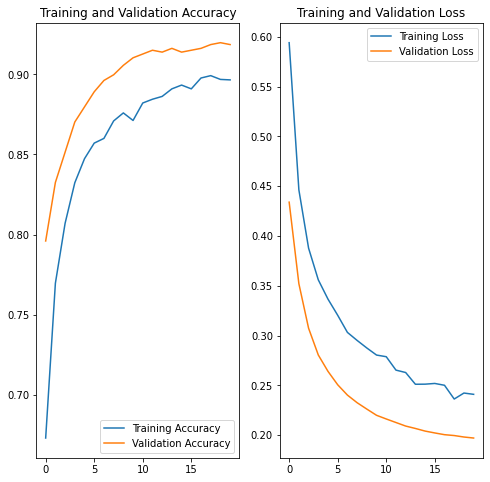

In [ ]:
# With this code, we will look at the performance during training 
# and validation steps using the history object as a result
# from model.fit()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model with the validation dataset
model.evaluate(val_ds, batch_size = 32, verbose = 1)

27/27 [==============================] - 1s 36ms/step - loss: 0.1971 - accuracy: 0.9186


[0.19710186123847961, 0.9186320900917053]

In [ ]:
# We can now make a prediction with our trained model

# Take a batch of images and labels from a dataset
# It can be the validation or test dataset
image_batch, label_batch = val_ds.as_numpy_iterator().next()

# Now we got the predictions with the flatten() method
predictions = model.predict_on_batch(image_batch).flatten()

# Now we use the sigmoid method from nn (neural network) to
# obtain logarithmic values (not labels like 0 or 1 which
# represent hotdog, or nothotdog)
predictions = tf.nn.sigmoid(predictions)

# Get the real predictions (0 or 1) 
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())  # Predicted Labels
print('Labels:\n', label_batch)               # Correct Labels

Predictions:
 [0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0]
Labels:
 [0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0]


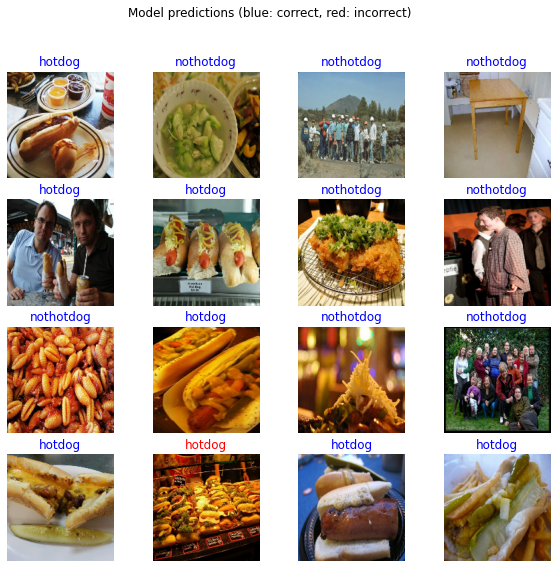

In [ ]:
# Compare the labels in plots
plt.figure(figsize = (10, 9))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    color = "blue" if predictions[i] == label_batch[i] else "red"
    plt.title(class_names[predictions[i]], color = color)
    plt.axis("off")

_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [ ]:
# Save the model
model.save('not_hotdog.h5')